In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sms-spam-collection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F483%2F982%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T134839Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D28935f6e26f828c462dc74e80482edc39b1946cafd437eaf16a529bb310a23027ddc313341fab431fc2184be9c534dac16be80001cd7b9b9b7abde9f41dfe82f3ee14437025513db87aa643bb5191b31df08a9c464d93974bffb8338daa3bba81fb2eb64f7298b735721b0c2d8af7bf30c5fbeec43a58a1eaaf1946116f2d2a1919e9ba89c301851cb7d5f4259a64f1594adfcda56825bc531b09e70a7f0b253843aa3657f311fc61feb4dc2d9034fd6713b1bd6d728f41d50a4d7ebfb3c109cc39511621e0f132dd707d7e5605b4898c2970d0b807187bf61c58339a4e1a309ec0089f640c9f77db59693a454582ef7d6be79dbed75205e49fcb8af0024b1ba'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 215934 bytes downloaded
Downloaded and uncompressed: sms-spam-collection-dataset
Data source import complete.


# SPAM SMS DETECTION

Import Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import nltk


## Import Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin1')

## Data Preprocessing

In [ ]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.shape

(5572, 5)

In [ ]:
# dropping unnecessary columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],inplace=True)
df.head()

In [ ]:
# renaming columns
df.rename(columns={'v1':'result','v2':'message'},inplace=True)
df

,result,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df.isnull().sum()

,0
result,0
message,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


In [ ]:
num_duplicates = df.duplicated().sum()
num_duplicates, df.shape #shape before dropping duplicates

(403, (5572, 5))

In [ ]:
#drop duplicates
df = df.drop_duplicates(keep='first')
df.shape #shape after dropping duplicates

(5169, 5)

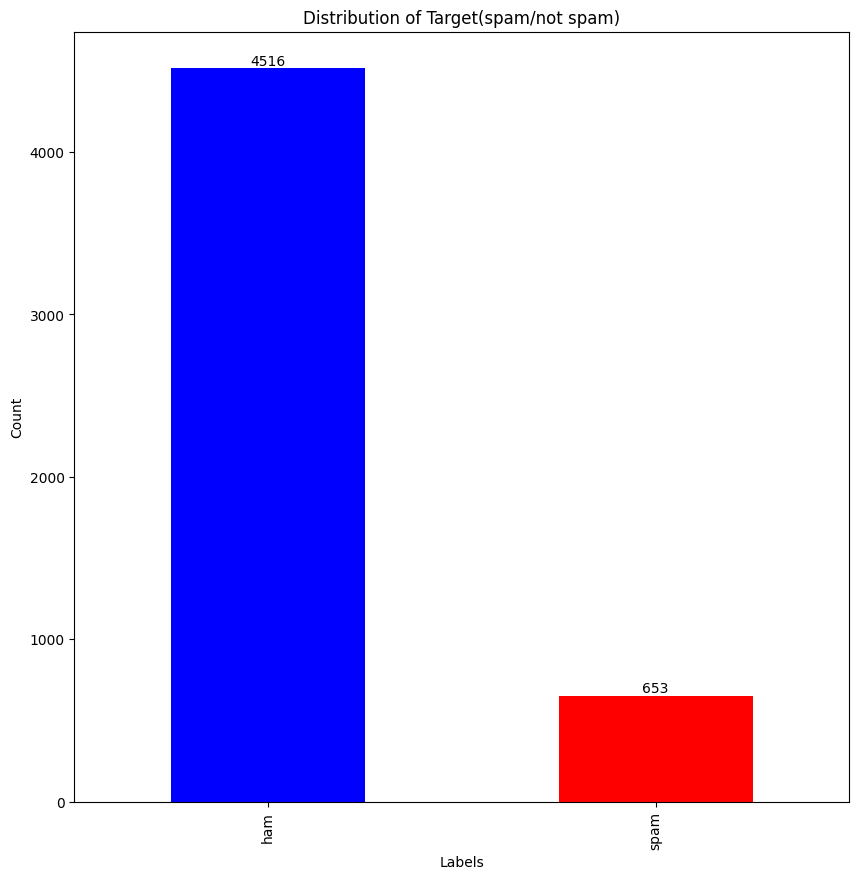

In [ ]:
value_counts = df['result'].value_counts()
value_counts

plt.figure(figsize=(10, 10))
ax = value_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Target(spam/not spam)')
plt.xlabel('Labels')
plt.ylabel('Count')

#add num above each col
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

One-hot encoding

In [ ]:
# Converting 'ham' to 0 and 'spam' to 1 (encoding)
df['result'] = df['result'].map({'ham': 0, 'spam': 1})
df['result']

<ipython-input-12-429079514f96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['result'] = df['result'].map({'ham': 0, 'spam': 1})


,result
0,0
1,0
2,1
3,0
4,0
...,...
5567,1
5568,0
5569,0
5570,0


In [ ]:
#get num of characters in each sms
df['no_of_char']=df['message'].apply(len)
df

<ipython-input-13-c5a100a244ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_of_char']=df['message'].apply(len)


,result,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,no_of_char
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61
...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN,161
5568,0,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN,37
5569,0,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN,57
5570,0,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN,125


In [ ]:
pip install nltk


Tokenizing

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Tokenize the 'message' (get each word individually ),count these words
tokenized_sms = []
length_of_sms = []

for sms in df['message']:
    tokens = nltk.word_tokenize(sms)
    tokenized_sms.append(tokens)
    length_of_sms.append(len(tokens))


df['tokenized_sms'] = tokenized_sms
df['no_of_words'] = length_of_sms


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
<ipython-input-18-391a430120f5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_sms'] = tokenized_sms
<ipython-input-18-391a430120f5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['no_of_words'] = length_of_sms


Sent Tokenizing is the process of dividing a text into individual sentences

In [ ]:
from nltk.tokenize import sent_tokenize

#get num of sentence in each sms

num_sentences = []

for sms in df['message']:
    sentences = sent_tokenize(sms)
    num_sentences.append(len(sentences))


df['num_of_sent'] = num_sentences

df.head()

<ipython-input-19-e991ccb6b39c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_of_sent'] = num_sentences


,result,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,no_of_char,tokenized_sms,no_of_words,num_of_sent
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,"[Go, until, jurong, point, ,, crazy, .., Avail...",24,2
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",37,2
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15,1


In [ ]:
#describe these 3 cols to get more info

df[['no_of_char','no_of_words','num_of_sent']].describe()

,no_of_char,no_of_words,num_of_sent
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
# describe these cols for ham sms/email
df[df['result']==0][['no_of_char','no_of_words','num_of_sent']].describe()


,no_of_char,no_of_words,num_of_sent
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [ ]:
# describe these cols for spam sms/email
df[df['result']==1][['no_of_char','no_of_words','num_of_sent']].describe()


,no_of_char,no_of_words,num_of_sent
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


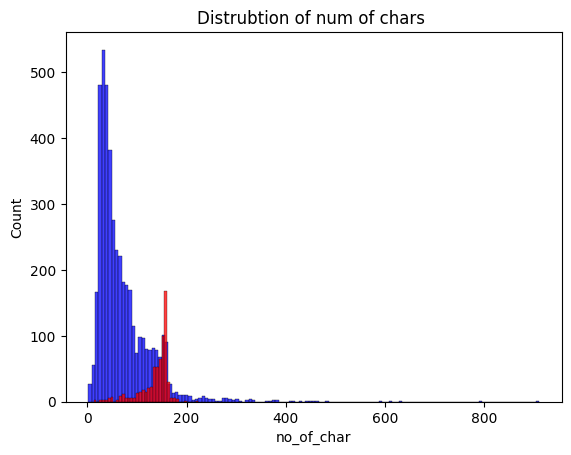

In [ ]:
import seaborn as sns
sns.histplot(df[df['result']==0]['no_of_char'],color='blue')
sns.histplot(df[df['result']==1]['no_of_char'],color='red')
plt.title('Distrubtion of num of chars ')
plt.show()

In [ ]:
df2=df[['result','no_of_char','no_of_words','num_of_sent']]
df2

,result,no_of_char,no_of_words,num_of_sent
0,0,111,24,2
1,0,29,8,2
2,1,155,37,2
3,0,49,13,1
4,0,61,15,1
...,...,...,...,...
5567,1,161,35,4
5568,0,37,9,1
5569,0,57,15,2
5570,0,125,27,1


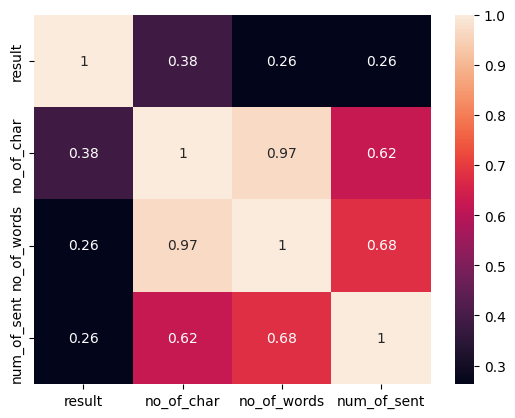

In [ ]:
sns.heatmap(df2.corr(),annot=True)
plt.show()

string.punctuation constant contains a string of all punctuation characters

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PorterStemmer is an algorithm for stemming

In [ ]:
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
ps.stem('dancing')

'danc'

stopwords list of common stopwords that arry little meaningful content

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
def process_txt(txt):
    txt=txt.lower() # cvt all sms to lower casechase letters
    txt=nltk.word_tokenize(txt)

    y=[]
    for i in txt: #include nums
        if i.isalnum()==True:
            y.append(i)
    txt=y[:]
    y.clear()

    for i in txt:
        if i not in stopwords.words('english')and i not in string.punctuation: # ignore stopwords & punctuation
            y.append(i)
    txt=y[:]
    y.clear()
    for i in txt:
        y.append(ps.stem(i)) #get stemming


    return " ".join(y)

In [ ]:
txt="hello 20 %"
process_txt(txt)

'hello 20'

In [ ]:
print(df['message'][2000])
print('_'*100)
print(process_txt(df['message'][2000]))

But i'll b going 2 sch on mon. My sis need 2 take smth.
____________________________________________________________________________________________________
b go 2 sch mon si need 2 take smth


In [ ]:
#apply fun to all data
df['text_transform']=df['message'].apply(process_txt)
df

<ipython-input-35-4c5e02f321f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_transform']=df['message'].apply(process_txt)


,result,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,no_of_char,tokenized_sms,no_of_words,num_of_sent,text_transform
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,111,"[Go, until, jurong, point, ,, crazy, .., Avail...",24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]",8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...",15,1,nah think goe usf live around though
...,...,...,...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN,161,"[This, is, the, 2nd, time, we, have, tried, 2,...",35,4,2nd time tri 2 contact u pound prize 2 claim e...
5568,0,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN,37,"[Will, Ì_, b, going, to, esplanade, fr, home, ?]",9,1,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN,57,"[Pity, ,, *, was, in, mood, for, that, ., So, ...",15,2,piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN,125,"[The, guy, did, some, bitching, but, I, acted,...",27,1,guy bitch act like interest buy someth els nex...


WordCloud is used for generating visual representations of word frequency in a text corpus

In [ ]:
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,min_word_length=4,background_color='black')

In [ ]:
spam_corpus=[]
for msg in df[df['result']==1]['text_transform'].tolist():
    for word in msg.split():
        spam_corpus.append(word)


# get the 50 most frequent words in spam emails/SMS
from collections import Counter
pd.DataFrame(Counter(spam_corpus).most_common(50))

,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


In [ ]:
ham_corpus=[]
for msg in df[df['result']==0]['text_transform'].tolist():
    for word in msg.split():
        ham_corpus.append(word)


# get the 50 most frequent words in ham emails/SMS
from collections import Counter
pd.DataFrame(Counter(ham_corpus).most_common(50))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


## Model Training and Testing

- CountVectorizer for converting a collection of text documents to a matrix of token counts.
- TfidfVectorizer for converting a collection of text documents to a matrix of TF-IDF features with a limit of features.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

#feature selection
X = tfidf.fit_transform(df['text_transform']).toarray()
y=df['result'].values

In [ ]:
from sklearn.model_selection import train_test_split

#splitting
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1,stratify=y,shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (4135, 3000)
Shape of y_train: (4135,)
Shape of X_test: (1034, 3000)
Shape of y_test: (1034,)


In [ ]:
from sklearn.naive_bayes import GaussianNB ,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score ,confusion_matrix,classification_report

BernoulliNB Model

0.9835589941972921
[[901   2]
 [ 15 116]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       903
           1       0.98      0.89      0.93       131

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



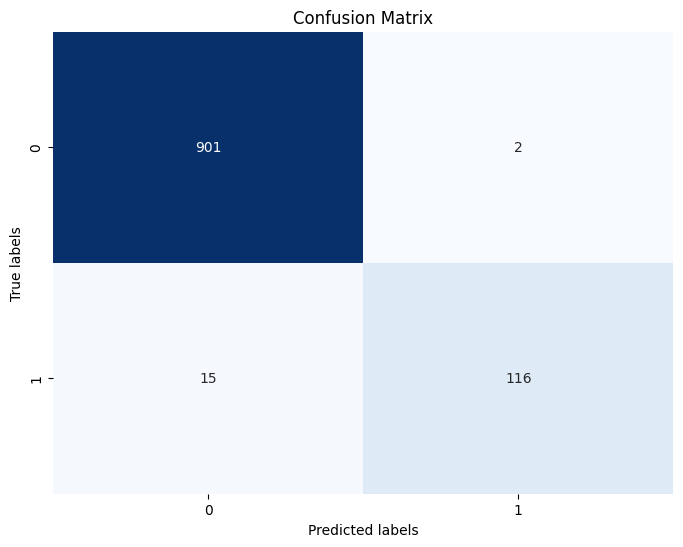

In [ ]:
bnb=BernoulliNB()


bnb.fit(X_train,y_train)
y_pred_bnb=bnb.predict(X_test)

print(accuracy_score(y_test,y_pred_bnb))
print(confusion_matrix(y_test,y_pred_bnb))
print(classification_report(y_test,y_pred_bnb))

cm = confusion_matrix(y_test, y_pred_bnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()